# TS2Vec based time series representation

![image](TS2Vec_schema.png)

This file contains an implementation of TS2Vec on two publicly available datasets: [ECG200 dataset](https://www.timeseriesclassification.com/description.php?Dataset=ECG200) and [CharacterTrajectories](https://archive.ics.uci.edu/dataset/175/character+trajectories). 

ECG200 dataset contains one time series feature of length 96 and 2 classes.

CharacterTrajectories dataset contains 3 time series features of length 182 and 20 classes.

The goal is to  learn a time series representation in an unsupervised or self-supervised manner such that the learnt representations can be good at the classification task.

Adapted from [official repo of TS2VEC](https://github.com/yuezhihan/ts2vec).

In [1]:
# check the current directory, set it as ts2vec
import os

if os.getcwd()!= '/home/trips/ContrastiveLearning_Tutorial/ts2vec':  # replace the path with your local path
    os.chdir('/home/trips/ContrastiveLearning_Tutorial/ts2vec')
print("Current working directory is : ", os.getcwd())

Current working directory is :  /home/trips/ContrastiveLearning_Tutorial/ts2vec


In [2]:
# importing packages
import os
import numpy as np
import pandas as pd
import math
import argparse
import random
import matplotlib.pyplot as plt
import json
import time
import datetime
from ts2vec_model import TS2Vec
from tasks import eval_classification
import datautils
from utils import init_dl_program, name_with_datetime, pkl_save, data_dropout
from sklearn.manifold import TSNE
from scipy.io.arff import loadarff
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import label_binarize
import matplotlib.cm as cm

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# function for initial loading and processing of the dataset
def load_UEA(dataset):
    train_data = loadarff(f'../Small_datasets/{dataset}/{dataset}_TRAIN.arff')[0]
    test_data = loadarff(f'../Small_datasets/{dataset}/{dataset}_TEST.arff')[0]
    
    def extract_data(data):
        res_data = []
        res_labels = []
        for t_data, t_label in data:
            t_data = np.array([ d.tolist() for d in t_data ])
            t_label = t_label.decode("utf-8")
            res_data.append(t_data)
            res_labels.append(t_label)
        return np.array(res_data).swapaxes(1, 2), np.array(res_labels)
    
    train_X, train_y = extract_data(train_data)
    test_X, test_y = extract_data(test_data)
    
    scaler = StandardScaler()
    scaler.fit(train_X.reshape(-1, train_X.shape[-1]))
    train_X = scaler.transform(train_X.reshape(-1, train_X.shape[-1])).reshape(train_X.shape)
    test_X = scaler.transform(test_X.reshape(-1, test_X.shape[-1])).reshape(test_X.shape)
    
    labels = np.unique(train_y)
    transform = { k : i for i, k in enumerate(labels)}
    train_y = np.vectorize(transform.get)(train_y)
    test_y = np.vectorize(transform.get)(test_y)
    return train_X, train_y, test_X, test_y

def load_UCR(dataset):
    train_file = os.path.join('../Small_datasets', dataset, dataset + "_TRAIN.tsv")
    test_file = os.path.join('../Small_datasets', dataset, dataset + "_TEST.tsv")
    train_df = pd.read_csv(train_file, sep='\t', header=None)
    test_df = pd.read_csv(test_file, sep='\t', header=None)
    train_array = np.array(train_df)
    test_array = np.array(test_df)

    # Move the labels to {0, ..., L-1}
    labels = np.unique(train_array[:, 0])
    transform = {}
    for i, l in enumerate(labels):
        transform[l] = i

    train = train_array[:, 1:].astype(np.float64)
    train_labels = np.vectorize(transform.get)(train_array[:, 0])
    test = test_array[:, 1:].astype(np.float64)
    test_labels = np.vectorize(transform.get)(test_array[:, 0])

    # Normalization for non-normalized datasets
    # To keep the amplitude information, we do not normalize values over
    # individual time series, but on the whole dataset
    if dataset not in [
        'AllGestureWiimoteX',
        'AllGestureWiimoteY',
        'AllGestureWiimoteZ',
        'BME',
        'Chinatown',
        'Crop',
        'EOGHorizontalSignal',
        'EOGVerticalSignal',
        'Fungi',
        'GestureMidAirD1',
        'GestureMidAirD2',
        'GestureMidAirD3',
        'GesturePebbleZ1',
        'GesturePebbleZ2',
        'GunPointAgeSpan',
        'GunPointMaleVersusFemale',
        'GunPointOldVersusYoung',
        'HouseTwenty',
        'InsectEPGRegularTrain',
        'InsectEPGSmallTrain',
        'MelbournePedestrian',
        'PickupGestureWiimoteZ',
        'PigAirwayPressure',
        'PigArtPressure',
        'PigCVP',
        'PLAID',
        'PowerCons',
        'Rock',
        'SemgHandGenderCh2',
        'SemgHandMovementCh2',
        'SemgHandSubjectCh2',
        'ShakeGestureWiimoteZ',
        'SmoothSubspace',
        'UMD'
    ]:
        return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels
    
    mean = np.nanmean(train)
    std = np.nanstd(train)
    train = (train - mean) / std
    test = (test - mean) / std
    return train[..., np.newaxis], train_labels, test[..., np.newaxis], test_labels

In [222]:
# initial setting and the dataset choice

dataset = "ECG200" # dataset name  "other option is CharacterTrajectories"
run_name = dataset+"_output"  # output data directory, 
gpu = 0  # what number gpu to use
batch_size=8  
lr=0.001  # learning rate
repr_dims=320  # representation dimension
max_train_length = 3000  # sequence with a length greater than max_train_length would be croppped
seed = 100  # random seed
task_type = 'classification' # evaluation task
irregular = 0.0 # initial missing observation ratio

In [223]:
# identifying the device
device = init_dl_program(gpu, seed=seed)
print(device)

cuda:0


In [224]:

# loading data
if dataset =="ECG200":
    train_data, train_labels, test_data, test_labels = load_UCR(dataset)
elif dataset =='CharacterTrajectories':
    train_data, train_labels, test_data, test_labels = load_UEA(dataset)

# data dimensions 
print(" Dataset name : ", dataset)
print(" Training data size :  ", train_data.shape)  # Number of samples * Length of the series * number of features
print(" Test data size :  ", test_data.shape)

 Dataset name :  ECG200
 Training data size :   (100, 96, 1)
 Test data size :   (100, 96, 1)


In [225]:
# whether to add missingness to the data or not
if irregular > 0:
    if task_type == 'classification':
        train_data = data_dropout(train_data, irregular)
        test_data = data_dropout(test_data, irregular)
    else:
        raise ValueError(f"Task type {task_type} is not supported when irregular>0.")
print('done')

done


In [226]:
# saving the output models
run_dir = './training/' + dataset + '__' + name_with_datetime(run_name)
os.makedirs(run_dir, exist_ok=True)

In [227]:
# tunable model parameters
config = dict(
    batch_size=batch_size,
    lr=lr,
    output_dims=repr_dims,
    max_train_length=max_train_length
)
t = time.time()

## Training the contrastive model

In [228]:
# training the model
model = TS2Vec(
    input_dims=train_data.shape[-1],
    device=device,
    **config
)
loss_log = model.fit(
    train_data,
    temperature=1,
    verbose=True
)
model.save(f'{run_dir}/model.pkl')

t = time.time() - t
print(f"\nTraining time: {datetime.timedelta(seconds=t)}\n")

Epoch #0: loss=5.7938306132952375
Epoch #1: loss=2.4303279916445413
Epoch #2: loss=2.1744321982065835
Epoch #3: loss=2.0398649672667184
Epoch #4: loss=2.0319308936595917
Epoch #5: loss=1.93396990497907
Epoch #6: loss=1.9789559443791707
Epoch #7: loss=1.8434029122193654
Epoch #8: loss=1.8314130703608196
Epoch #9: loss=1.762201448281606
Epoch #10: loss=1.7647224466005962
Epoch #11: loss=1.6285368204116821
Epoch #12: loss=1.8184629678726196
Epoch #13: loss=1.7900168001651764
Epoch #14: loss=1.7120609283447266
Epoch #15: loss=1.6289512813091278

Training time: 0:00:09.992579



In [229]:
# obtain the train and test data embeddings
train_repr = model.encode(train_data, encoding_window='full_series' if train_labels.ndim == 1 else None)
test_repr = model.encode(test_data, encoding_window='full_series' if train_labels.ndim == 1 else None)

## Visualize the embeddings using t-sne

/home/trips/Virtual_env_python/lib64/python3.9/site-packages/sklearn/manifold/_t_sne.py:991: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


Text(0.5, 1.0, 'Dataset : ECG200 \n tsne reduced representation of time series')

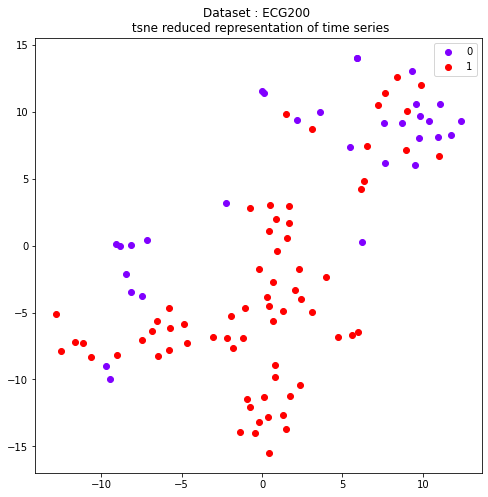

In [230]:
tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=15)
reduced = tsne.fit_transform(train_repr)

# obtaining unique labels
unique_labels = np.unique(train_labels)

fig, ax = plt.subplots(figsize=(8, 8))

colors = cm.rainbow(np.linspace(0, 1, len(unique_labels)))

for label, col in zip(unique_labels, colors):
    indices = [i for i, l in enumerate(train_labels) if l == label]
    
    current_tx = np.take(reduced[:,0], indices)
    current_ty = np.take(reduced[:,1], indices)
    
    ax.scatter(current_tx, current_ty, color=col, label=label)
    
# build a legend using the labels we set previously
plt.legend(loc='best')
plt.title("Dataset : "+dataset +" \n tsne reduced representation of time series")

## Linear evaluation

In [231]:
# Linear evaluation of the model
# modelname can 'knn', 'svm', 'xgbt', 'linear'
modelname = 'svm'
out, eval_res = eval_classification(model, train_data, train_labels, test_data, test_labels, eval_protocol=modelname)

In [232]:
# Saving the model and printing the results
pkl_save(f'{run_dir}/out.pkl', out)
pkl_save(f'{run_dir}/eval_res.pkl', eval_res)
print("Dataset : ", dataset, " trained on a ", modelname, " classifier " )
print('Evaluation result:', eval_res)

Dataset :  ECG200  trained on a  svm  classifier 
Evaluation result: {'acc': 0.93, 'auprc': 0.9808411634587798, 'auroc': 0.9618055555555555}


### Exercises:

1) We saw the role of batchsize in CL. Does TS@Vec gets impacted by the batchsize? Can you evaluate the quality of representation learnt as batchsize changes?

2) Experiment by plotting different tsne plots corresponding to different learnt representation dimension. Can you identify a value of repr-dims that learns more task-relevant information?

3) Does adding missingness (using the parameter 'irregular') helps?